# Statistical testing
In this notebook we will use `bia_bob` to apply a statistical test to some example data. The data is tricky (for a reason).

For training purposes, we will use the LLM infrastructure of [ScaDS.AI](https://scads.ai) in the [National Compute Center ZIH TU Dresden](https://tu-dresden.de/zih).

When using bia-bob to prompt LLMs, the prompts you enter including existing variable names etc. are sent to the LLM provider. 
Do not submit any sensitive, secret or private information. Also check bia-bob's code recommendations before executing them. 
LLMs make mistakes.

First, we configure bia-bob:

In [1]:
# load secret API key. You must unpack the contents of api_key.zip 
# into the same folder before going ahead.
#from dotenv import load_dotenv
#load_dotenv()

import os
from bia_bob import bob
bob.initialize(endpoint='https://llm.scads.ai/v1', model='openai/gpt-oss-120b', api_key=os.environ.get('SCADSAI_API_KEY'))

## The over-simplified approach
In the first attempt, we ask to determine if columns `A` and `B` are significantly different without any further instructions.

In [3]:
%%bob load data/data.csv and 
determine if the columns A and B 
are significantly different.

I will load `data/data.csv`, extract columns **A** and **B**, and test whether their means differ significantly using an independent two‑sample t‑test. The result (t‑statistic and p‑value) will be printed, and a quick box‑plot will be shown for visual comparison.



t‑statistic: -1.3287
p‑value: 1.8428e-01
=> No statistically significant difference detected (α=0.05).


C:\Users\rober\AppData\Local\Temp\ipykernel_23620\3276436669.py:29: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([a, b], labels=['A', 'B'])


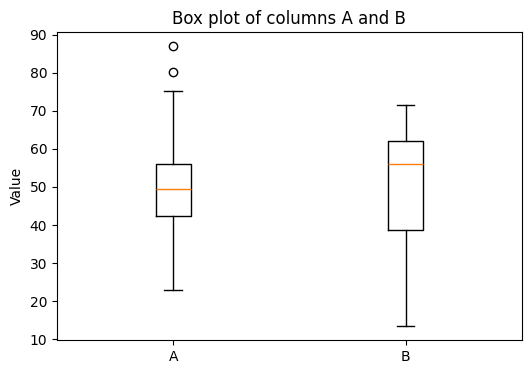

In [4]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt

# 1. Load the CSV file
df = pd.read_csv('data/data.csv')

# 2. Keep only rows where both A and B are present
df = df[['A', 'B']].dropna()

# 3. Extract the two series
a = df['A'].values
b = df['B'].values

# 4. Perform independent two‑sample t‑test
t_stat, p_val = ttest_ind(a, b, equal_var=False)  # Welch's t‑test

# 5. Output the results
print(f"t‑statistic: {t_stat:.4f}")
print(f"p‑value: {p_val:.4e}")
if p_val < 0.05:
    print("=> The difference between columns A and B is statistically significant (α=0.05).")
else:
    print("=> No statistically significant difference detected (α=0.05).")

# 6. Visual comparison: box‑plot
plt.figure(figsize=(6, 4))
plt.boxplot([a, b], labels=['A', 'B'])
plt.title('Box plot of columns A and B')
plt.ylabel('Value')
plt.show()

This result might be misleading, simply because we didn't study the data yet.
Let's plot the data.

In [5]:
%%bob
Plot histograms for A and B

I will create histograms for the values in columns **A** and **B** of the already‑loaded `data/data.csv`. The histograms will be displayed side‑by‑side for easy visual comparison.



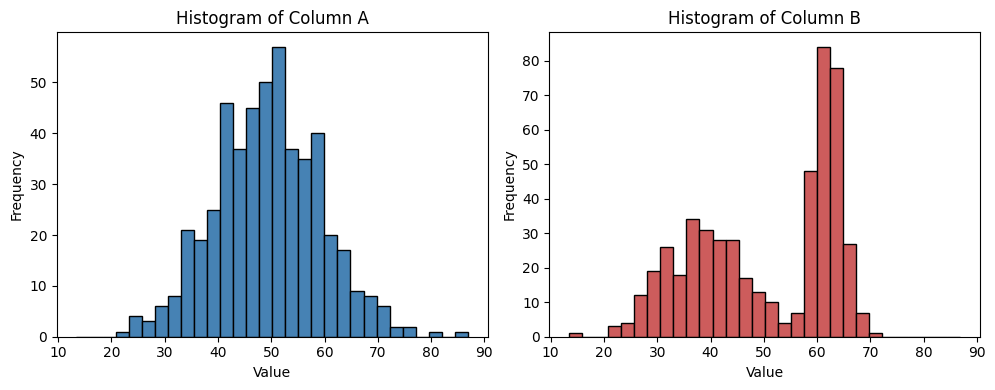

In [6]:
# Assuming df, a, b are already defined from the previous step.
# If not, uncomment the following lines to load them again:
# import pandas as pd
# df = pd.read_csv('data/data.csv')[['A','B']].dropna()
# a = df['A'].values
# b = df['B'].values

# Determine a common bin range for both histograms
min_val = min(a.min(), b.min())
max_val = max(a.max(), b.max())
bins = 30  # you can adjust the number of bins

plt.figure(figsize=(10, 4))

# Histogram for column A
plt.subplot(1, 2, 1)
plt.hist(a, bins=bins, range=(min_val, max_val), color='steelblue', edgecolor='black')
plt.title('Histogram of Column A')
plt.xlabel('Value')
plt.ylabel('Frequency')

# Histogram for column B
plt.subplot(1, 2, 2)
plt.hist(b, bins=bins, range=(min_val, max_val), color='indianred', edgecolor='black')
plt.title('Histogram of Column B')
plt.xlabel('Value')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

From this visualization we can guess that the data in B is not normal distributed; a pre-condition for the T-test used above.

## Professional statistical testing
An improved prompt contains an additional task: Checking preconditions. Hence, the resulting code will be longer and more detailed.

In [7]:
%%bob
Please test again if columns A and B are significantly different.
Before applying a statistical test, ensure that the necessary 
pre-conditions are met.

I will re‑evaluate whether columns **A** and **B** differ significantly, but first I will check the required assumptions:

1. **Normality** of each column (Shapiro‑Wilk test).  
2. **Equality of variances** (Levene’s test).  

Based on those results I will choose the appropriate statistical test:

* Both normal & equal variances → classic Student’s t‑test.  
* Both normal & unequal variances → Welch’s t‑test.  
* Any non‑normal → Mann‑Whitney U test (non‑parametric).

The results of all tests (statistics and p‑values) will be printed.



In [8]:
from scipy.stats import shapiro, levene, mannwhitneyu
# Note: pandas (pd), numpy (np), and ttest_ind are already available.

# 1. Load data (keep original df/a/b untouched)
data_path = 'data/data.csv'
df_raw = pd.read_csv(data_path)
# keep only rows where both A and B are present
df_clean = df_raw[['A', 'B']].dropna()
a_vals = df_clean['A'].values
b_vals = df_clean['B'].values

# 2. Normality tests (Shapiro‑Wilk)
shapiro_a_stat, shapiro_a_p = shapiro(a_vals)
shapiro_b_stat, shapiro_b_p = shapiro(b_vals)

# 3. Equality of variances (Levene)
lev_stat, lev_p = levene(a_vals, b_vals)

# 4. Choose appropriate hypothesis test
if shapiro_a_p > 0.05 and shapiro_b_p > 0.05:
    # both distributions look normal
    if lev_p > 0.05:
        test_name = "Student's t‑test (equal variances)"
        t_stat, p_val = ttest_ind(a_vals, b_vals, equal_var=True)
    else:
        test_name = "Welch's t‑test (unequal variances)"
        t_stat, p_val = ttest_ind(a_vals, b_vals, equal_var=False)
else:
    # at least one non‑normal → use non‑parametric test
    test_name = "Mann‑Whitney U test (non‑parametric)"
    # two-sided test
    t_stat, p_val = mannwhitneyu(a_vals, b_vals, alternative='two-sided')

# 5. Print report
print("=== Assumption checks ===")
print(f"Shapiro‑Wilk A:  statistic={shapiro_a_stat:.4f}, p={shapiro_a_p:.4e} "
      f"{'normal' if shapiro_a_p>0.05 else 'non‑normal'}")
print(f"Shapiro‑Wilk B:  statistic={shapiro_b_stat:.4f}, p={shapiro_b_p:.4e} "
      f"{'normal' if shapiro_b_p>0.05 else 'non‑normal'}")
print(f"Levene variance test: statistic={lev_stat:.4f}, p={lev_p:.4e} "
      f"{'equal variances' if lev_p>0.05 else 'unequal variances'}")
print("\n=== Final hypothesis test ===")
print(f"Test used: {test_name}")
print(f"Statistic = {t_stat:.4f}")
print(f"P‑value   = {p_val:.4e}")
if p_val < 0.05:
    print("=> Significant difference between columns A and B (α=0.05).")
else:
    print("=> No significant difference detected (α=0.05).")

=== Assumption checks ===
Shapiro‑Wilk A:  statistic=0.9972, p=5.6236e-01 normal
Shapiro‑Wilk B:  statistic=0.8937, p=4.0635e-18 non‑normal
Levene variance test: statistic=80.6718, p=1.3016e-18 unequal variances

=== Final hypothesis test ===
Test used: Mann‑Whitney U test (non‑parametric)
Statistic = 113657.0000
P‑value   = 1.3000e-02
=> Significant difference between columns A and B (α=0.05).


The result is now different: This test _sees_ the differences between the datasets.